In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tsnecuda import TSNE
from tqdm import tqdm
import pandas as pd
import numpy as np
import torchvision
import importlib
import imageio

import torch
import re

import train_encode_decode
import multiview_dataset
from rhodin.python.utils import datasets as rhodin_utils_datasets

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
device

'cuda:0'

In [3]:
class IgniteTestNVS(train_encode_decode.IgniteTrainNVS):
    def run(self, config_dict_file, config_dict):
        config_dict['n_hidden_to3Dpose'] = config_dict.get('n_hidden_to3Dpose', 2)

        data_loader = self.load_data_test(config_dict)

        # load model
        model = self.load_network(config_dict)
        model = model.to(device)

        return model, data_loader, config_dict
    
def predict(model, input_dict, label_dict):
    model.eval()
    with torch.no_grad():
        input_dict_cuda, label_dict_cuda = rhodin_utils_datasets.nestedDictToDevice((input_dict, label_dict), device=device)
        output_dict_cuda = model(input_dict_cuda)
        output_dict = rhodin_utils_datasets.nestedDictToDevice(output_dict_cuda, device='cpu')
    return output_dict

def nextImage(data_iterator):
    input_dict, label_dict = next(data_iterator)
    return input_dict, label_dict

def get_config_model_and_iterator(config_path, train_subjects, test_subjects, batch_size_test):
    config_dict_module = multiview_dataset.rhodin_utils_io.loadModule(config_path)
    config_dict = config_dict_module.config_dict
    config_dict['train_subjects'] = train_subjects
    config_dict['test_subjects'] = test_subjects
    config_dict['batch_size_test'] = batch_size_test
    ignite = IgniteTestNVS()
    model, data_loader, config_dict = ignite.run(config_dict_module.__file__, config_dict)
    data_iterator = iter(data_loader)
    return config_dict, model, data_iterator

In [4]:
def get_labels_for_whole_test_set(model, data_iterator, config_dict):
    iterations = int(len(data_iterator)/config_dict['batch_size_test'])
    pains = []
    views = []
    latent_3d = []
    with tqdm(total=iterations) as pbar:
        for i in range(iterations):
            pbar.update(1)
            input_dict, label_dict = nextImage(data_iterator)
            output_dict = predict(model, input_dict, label_dict)
            pains.append(label_dict['pain'])
            views.append(label_dict['view'])
            latent_3d.append(output_dict['latent_3d'])
    return pains, views, latent_3d

def prepare_data_for_TSNE(pains, views, latent_3d):
    X = np.concatenate(latent_3d)
    X = np.reshape(X, (X.shape[0], -1))
    pains = np.concatenate(pains)
    views = np.concatenate(views)
    return pains, views, X

def plot_TSNE(X_embedded, labels):
    plt.figure()
    plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels)
    plt.show()

### Getting pains, views and latent_3d took 13 minutes for one test horse

#### The below gave a memory error on 5GB RAM (when getting img_crop also)

In [ ]:
pains, views, latent_3d, img_crop = get_labels_for_whole_test_set(model, data_iterator, config_dict)

 29%|██▉       | 210/719 [06:34<4:13:13, 29.85s/it]

In [8]:
pains, views, latent_3d = get_labels_for_whole_test_set(model, data_iterator, config_dict)

100%|██████████| 719/719 [13:21<00:00,  1.12s/it]


### Plot the rep for one model

Iterating over frame indices per subject (.csv files)
Iterating over frame indices per subject (.csv files)


 47%|████▋     | 54268/115183 [00:00<00:00, 542679.22it/s]

Establishing sequence association. Available labels: ['Unnamed: 0', 'Unnamed: 0.1', 'interval', 'interval_ind', 'view', 'subject', 'pain', 'frame']


100%|██████████| 115183/115183 [00:00<00:00, 486087.37it/s]


DictDataset: Done initializing, listed 28800 viewsets (28783 frames) and 8 sequences
bottleneck_resolution 16 num_output_features 32768
Loading weights from config_dict['pretrained_network_path']
Transferring weights...


 11%|█▏        | 3245/28783 [00:00<00:00, 32448.87it/s]

Copied 131 elements, 0 skipped, and 0 target params without source
Done loading weights from config_dict['pretrained_network_path']
Randomizing dataset (MultiViewDatasetSampler.__iter__)


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


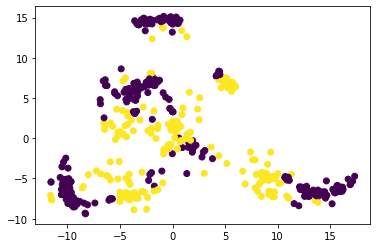

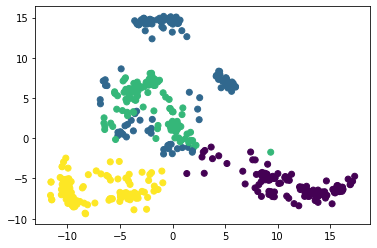

In [7]:
# Specify the fold for the model you trained on
train_subjects = 'aslan/brava/herrera/inkasso/julia/kastanjett/sir_holger'
test_subjects = 'naughty_but_nice'
train_subjects = re.split('/', train_subjects)
test_subjects = re.split('/', test_subjects)
config_path = 'configs/config_test.py'
batch_size_test = 100

# Load model and data
config_dict, model, data_iterator = get_config_model_and_iterator(config_path,
                                                                  train_subjects,
                                                                  test_subjects,
                                                                  batch_size_test)
# Get the latent rep with labels to visualize
pains, views, latent_3d = get_labels_for_whole_test_set(model, data_iterator, config_dict)

pains, views, X = prepare_data_for_TSNE(pains, views, latent_3d)
X_embedded = TSNE().fit_transform(X)

# Plot with relevant labels
plot_TSNE(X_embedded, pains)
plot_TSNE(X_embedded, views)